In [1]:
base_dir = "./benchmark-earthquake-dataset"
indicators_adeli = "Adeli and Panakkat seismicity indicators"
indicators_reyes = "Reyes et al. seismicity indicators"

aggregation = "1_week" # 1_week, 2_weeks or 1_month

In [2]:
import os

def list_files(base_dir, indicators, aggregation):
    file_names = os.listdir(os.path.join(base_dir, indicators_adeli))
    return [os.path.join(base_dir, indicators, f) for f in file_names if aggregation in f]

adeli_files = list_files(base_dir, indicators_adeli, aggregation)
reyes_files = list_files(base_dir, indicators_reyes, aggregation)

In [3]:
adeli_files

['./benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/japan_AP_1_week.csv',
 './benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/chile_AP_1_week.csv',
 './benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/california_AP_1_week.csv',
 './benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/sicily_AP_1_week.csv',
 './benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/hindukush_AP_1_week.csv']

In [4]:
reyes_files

['./benchmark-earthquake-dataset/Reyes et al. seismicity indicators/japan_AP_1_week.csv',
 './benchmark-earthquake-dataset/Reyes et al. seismicity indicators/chile_AP_1_week.csv',
 './benchmark-earthquake-dataset/Reyes et al. seismicity indicators/california_AP_1_week.csv',
 './benchmark-earthquake-dataset/Reyes et al. seismicity indicators/sicily_AP_1_week.csv',
 './benchmark-earthquake-dataset/Reyes et al. seismicity indicators/hindukush_AP_1_week.csv']

Варианты обучения:
    - Одна модель на один регион для данного набора индикаторов
    - Одна модель на один регион для объединения наборов индикаторов
    - Одна модель на все регионы для данного набора индикаторов (NB: качество считаем по разным регионам по отдельности)
    - Одна модель на все регионы для объединения наборов индикаторов (NB: качество считаем по разным регионам по отдельности)
    - --//-- добавляя разные срезы (1 неделя + 2 недели + 1 месяц)

In [5]:
file_path = adeli_files[0]
file_path

'./benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/japan_AP_1_week.csv'

In [6]:
import pandas as pd
df = pd.read_csv(file_path, sep='\t', index_col='time')

In [7]:
df.head()

,b-value,Mean square deviation,Magnitude deficit,Elapsed days,Mean magnitude,Rate of square root of energy released,Mean time between characteristic events,Coefficient of variation from mean time,mag
time,,,,,,,,,
1974-11-03,0.885901,0.016903,-0.405367,2442.0,5.069,3.188734e+08,49.502163,0.505586,5.1
1974-11-10,0.932661,0.016015,-0.292516,2358.0,5.047,3.139430e+08,49.502163,0.505586,0.0
1974-11-17,0.932661,0.016015,-0.292516,2358.0,5.047,3.139430e+08,49.502163,0.505586,5.8
1974-11-24,0.958862,0.017196,-0.240018,2328.0,5.044,3.128035e+08,49.502163,0.505586,4.5
1974-12-01,0.959048,0.015079,-0.228382,2296.0,5.031,3.102384e+08,49.502163,0.505586,0.0


Нас интересует значение mag - максимальная амплитуда за данный диапазон (1_week/2_weeks/1_month)

Модель должна предсказывать mag на следующую неделю по некоторому количеству предыдущих семплов lookback. 

Как должен выглядеть датасет?

Пусть lookback = 3

x0, x1, x2, x3, ... xn - наш датасет 

Тогда у нас вот такие семплы:

x0, x1, x2 -> x3

x1, x2, x3 -> x4

...

xn-3, xn-2, xn-1 -> xn


Надо иметь в виду что у нас входные данные - векторы (фичей много). Но предсказываем число

Данные бьем на трейн/тест в соотношении 75%/25% по датам (данные уже упорядочены по ним)

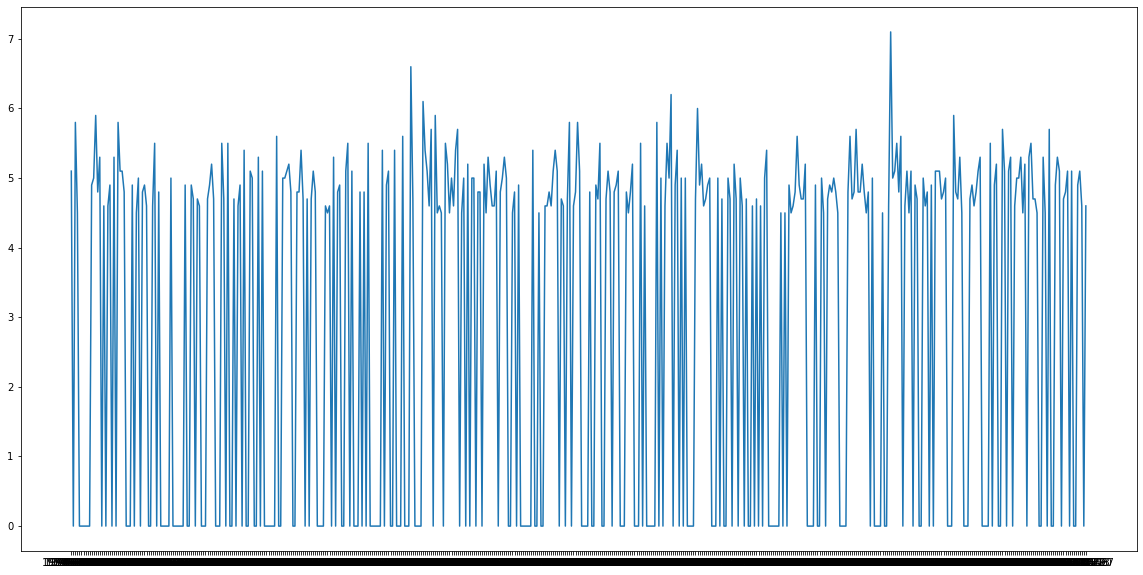

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10)) 
plt.plot(df.mag[:500])
plt.show()

Можно решать как задачу регрессии, а можно как задачу бинарной классификации (будет ли землетрясение выше заданного порога)

Пороги:

In [9]:
sicily_thresh = 3.2
japan_thresh = 5
chile_thresh = 4.5
hindukush_thresh = 4.8
california_thresh = 4

In [10]:
df.mag = (df.mag > california_thresh).astype(int)
data = df.values
data.shape

(2306, 9)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

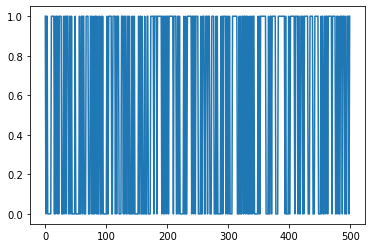

In [12]:
plt.plot(data[:500, -1])

In [49]:
import numpy as np

def samples_preparation(data, lookback):
    X = []
    y = []
    for batch_start in range(len(data) - lookback - 1):
        batch = []
        for batch_ind in range(0, lookback):
            batch.append(data[batch_start + batch_ind, :])
        X.append(batch)
        y.append(data[batch_start + lookback, -1])
    
    return np.array(X), np.array(y)

In [50]:
lookback = 10 # ПОПРОБОВАТЬ РАЗНЫЕ ПАРАМЕТРЫ

X, y = samples_preparation(data, lookback)

In [51]:
X.shape

(2295, 10, 9)

In [52]:
y.shape

(2295,)

In [53]:
print(X[0, :, -1])
print(y[0])

[1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
1.0


In [54]:
print(X[1, :, -1])
print(y[1])

[0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
1.0


In [55]:
def train_test_split(X, y, test_fraction = 25./100):
    num_samples = len(X)
    test_size = int(len(X) * test_fraction)
    train_size = num_samples - test_size
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:]

In [56]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

In [57]:
X_train.shape

(1722, 10, 9)

In [58]:
y_train.shape

(1722,)

In [59]:
X_test.shape

(573, 10, 9)

In [60]:
y_test.shape

(573,)

In [61]:
y

array([1., 1., 1., ..., 1., 0., 1.])

Наиболее тупая модель:

In [62]:
# Для регрессии:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, np.ones(len(y_test)) * np.mean(y_test))

0.17444697239659

In [63]:
X_train.shape

(1722, 10, 9)

In [64]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [65]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train.reshape(-1, 1)))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test.reshape(-1,1)))

In [66]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [67]:
import torch.nn as nn

In [135]:
class SimpleNN(nn.Module):
    def __init__(self, hidden_size=256, num_rnn_layers=2):
        super(SimpleNN, self).__init__()
        self.rnn = nn.LSTM(input_size=9, hidden_size=hidden_size,
                           batch_first=True, num_layers=num_rnn_layers)
        self.dense = nn.Linear(hidden_size, 1)
        
        
    def forward(self, x):
        out, (hidden, _) = self.rnn(x)
        out = out[:, -1, :]
        hidden = hidden[-1]
        x = self.dense(hidden)
        return x

In [136]:
model = SimpleNN()

In [142]:
from torch.optim import Adam, SGD
from torch.nn import BCEWithLogitsLoss,  MSELoss

optimizer = Adam(model.parameters())
# optimizer = SGD()
loss = BCEWithLogitsLoss()

In [145]:
from tqdm import tqdm

epoch_count = 30
for epoch_num in range(epoch_count):
    loss_values = [] 
    for batch_num, batch in enumerate(tqdm(train_loader)):
        inp, targets = batch
        optimizer.zero_grad()
        output = model(inp)
        loss_value = loss(output, targets)
        loss_value.backward()
        optimizer.step()
        loss_values.append(loss_value.item())
    

    print(f"Epoch {epoch_num} / {epoch_count} | train loss = {np.mean(loss_values)}")

    

100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.47it/s]


Epoch 0 / 30 | train loss = 0.6727588110499911


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.05it/s]


Epoch 1 / 30 | train loss = 0.6738552489766368


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.72it/s]


Epoch 2 / 30 | train loss = 0.671737766928143


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.38it/s]


Epoch 3 / 30 | train loss = 0.6694129446038494


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.70it/s]


Epoch 4 / 30 | train loss = 0.6682888291500233


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.21it/s]


Epoch 5 / 30 | train loss = 0.6694061750615085


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.32it/s]


Epoch 6 / 30 | train loss = 0.6648077650202645


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.14it/s]


Epoch 7 / 30 | train loss = 0.6642971127121536


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.71it/s]


Epoch 8 / 30 | train loss = 0.6687595811155107


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.08it/s]


Epoch 9 / 30 | train loss = 0.6633806123777672


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.54it/s]


Epoch 10 / 30 | train loss = 0.6554218182961146


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.46it/s]


Epoch 11 / 30 | train loss = 0.652130569020907


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.44it/s]


Epoch 12 / 30 | train loss = 0.649016413975645


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.72it/s]


Epoch 13 / 30 | train loss = 0.6492700858248605


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.49it/s]


Epoch 14 / 30 | train loss = 0.646971432975045


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.98it/s]


Epoch 15 / 30 | train loss = 0.6514243842275055


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.13it/s]


Epoch 16 / 30 | train loss = 0.6503379916151365


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 50.76it/s]


Epoch 17 / 30 | train loss = 0.6466080143495843


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.36it/s]


Epoch 18 / 30 | train loss = 0.6336553811475083


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.12it/s]


Epoch 19 / 30 | train loss = 0.633217422498597


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.07it/s]


Epoch 20 / 30 | train loss = 0.6320323778523339


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 44.59it/s]


Epoch 21 / 30 | train loss = 0.6771736873520745


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.49it/s]


Epoch 22 / 30 | train loss = 0.6557549685239792


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 42.65it/s]


Epoch 23 / 30 | train loss = 0.6518258038494322


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 48.84it/s]


Epoch 24 / 30 | train loss = 0.6341070160269737


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.45it/s]


Epoch 25 / 30 | train loss = 0.6361844650021306


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 45.73it/s]


Epoch 26 / 30 | train loss = 0.6319100699490972


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 49.48it/s]


Epoch 27 / 30 | train loss = 0.6224112317517951


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.04it/s]


Epoch 28 / 30 | train loss = 0.6165928211477067


100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 51.42it/s]

Epoch 29 / 30 | train loss = 0.6149766475514129


In [150]:
targets = []
outputs = []
scores = []
for batch_num, batch in enumerate(tqdm(test_loader)):
    inp, target = batch
    output = model(inp)
    output = output.detach().numpy() > 0.5
    target = target.detach().numpy()
    
    scores.append(accuracy_score(target, output))
    
print('Test accuracy:', np.mean(scores))

100%|██████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 101.84it/s]

Test accuracy: 0.6034989316239316


In [149]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [151]:
X_train.shape

(1722, 10, 9)

In [152]:
log_reg.fit(X_train.reshape(-1, 90), y_train)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [155]:
log_reg.score(X_train.reshape(-1, 90), y_train)

0.5923344947735192